# Первая часть проекта. Эксперименты

## 3. Подбор $\mathcal{A}$ при фиксированных параметрах распределений.

### 3.1. Для конкретного n, с иллюстрациями

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from dataclasses import dataclass
from tqdm import tqdm
from itertools import product

from graphs import KNN_Graph, Distance_Graph
from characteristics_experimental import *
from visualisations import *
from metrics import *

In [2]:
n_param = 100
lambda_param = 2 / np.sqrt(3)
alpha_param = 3

In [3]:
k = 15
d = 0.005

In [4]:
exp_points = []
pareto_points = []

for _ in tqdm(range(500)):
    numbers_exp = np.random.exponential(1/lambda_param, n_param)
    numbers_pareto = (np.random.pareto(alpha_param, n_param) + 1)

    # в свете результатов первых двух экспериментов используем характеристики ДИСТАНЦИОННОГО графа
    distance_graph_exp = Distance_Graph(n=n_param, d_distance=d)
    distance_graph_pareto = Distance_Graph(n=n_param, d_distance=d)
    distance_graph_exp.build_from_numbers(numbers_exp)
    distance_graph_pareto.build_from_numbers(numbers_pareto)

    chars = create_characteristics(None, distance_graph_exp, None, distance_graph_pareto, "dist")

    exp_points.append((chars.distance_exp_components, chars.distance_pareto_chromatic))
    pareto_points.append((chars.distance_pareto_components, chars.distance_pareto_chromatic))

100%|██████████| 500/500 [00:03<00:00, 126.28it/s]


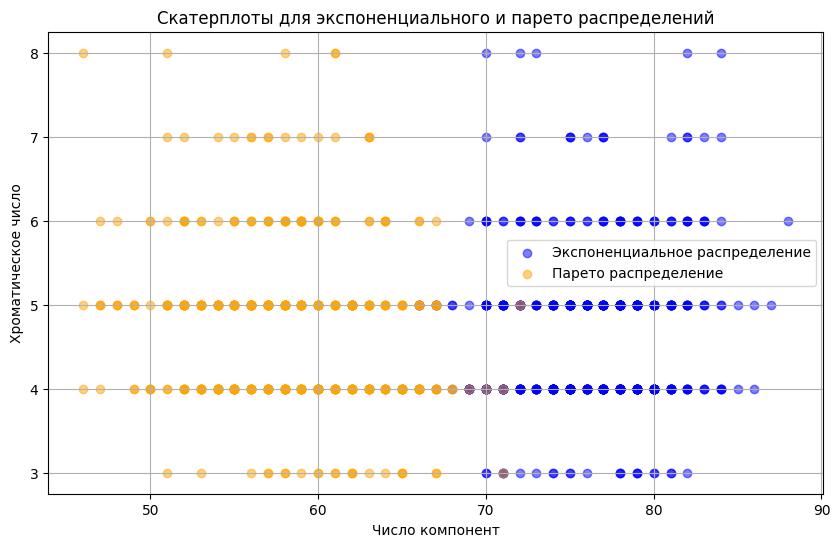

In [5]:
draw_two_points_sets(exp_points, pareto_points, title='Скатерплоты для экспоненциального и парето распределений',
                     xlabel='Число компонент', ylabel='Хроматическое число',
                     first_legend='Экспоненциальное распределение', second_legend='Парето распределение')

In [6]:
exp_points = np.array(exp_points)
pareto_points = np.array(pareto_points)

unique_exp_points = np.unique(exp_points, axis=0)
unique_pareto_points = np.unique(pareto_points, axis=0)

In [7]:
A = unique_exp_points.copy()
np.random.shuffle(A) # это задаток. далее будем по многу раз перемешивать и брать лучший результат
I_errors = []
powers = []
for i in tqdm(range(A.size)):
    points_powers = {}

    for exp_point_to_remove in A:
        A_new = A[~np.all(A == exp_point_to_remove, axis=1)]

        # calc I error
        I_error = calc_I_error(A_new, exp_points)

        I_errors.append(I_error)

        if I_error >= 0.05:
            continue

        # lucky. calc and save power
        power = calc_power(A_new, pareto_points)

        points_powers[tuple(exp_point_to_remove)] = power

        powers.append(power)

    if len(points_powers) == 0:
        continue

    best_point_to_remove = max(points_powers, key=points_powers.get)
    A = A[~np.all(A == best_point_to_remove, axis=1)]

100%|██████████| 176/176 [00:18<00:00,  9.40it/s]


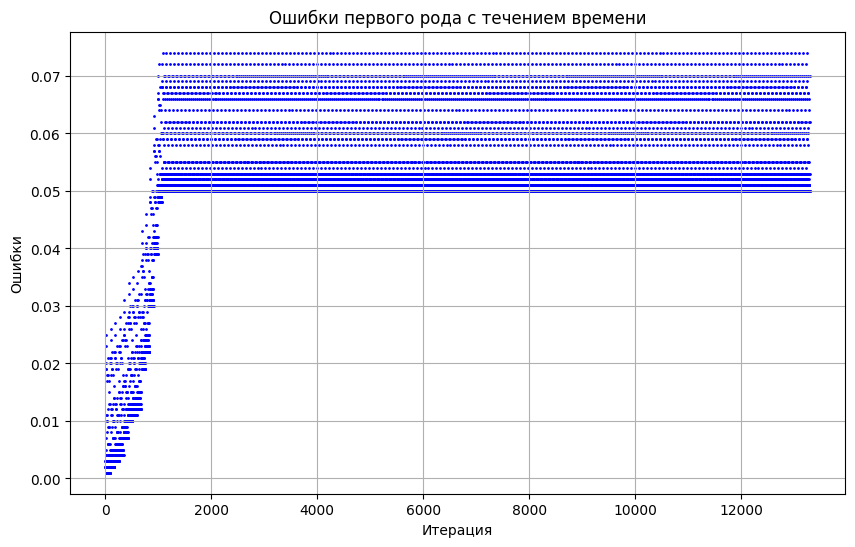

In [8]:
draw_numbers_indexes_scatter(I_errors, title='Ошибки первого рода с течением времени',
                             xlabel='Итерация', ylabel='Ошибки')

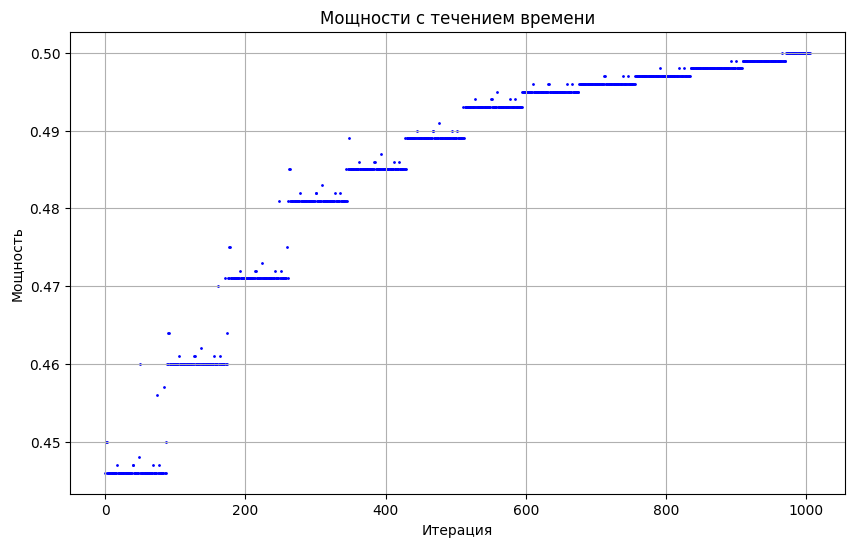

In [9]:
draw_numbers_indexes_scatter(powers, title='Мощности с течением времени',
                             xlabel='Итерация', ylabel='Мощность')

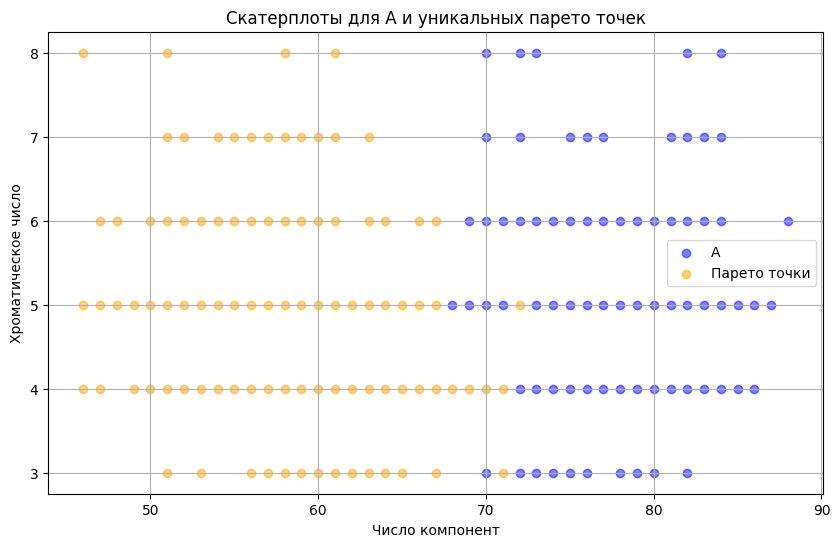

In [10]:
draw_two_points_sets(A, unique_pareto_points, title='Скатерплоты для A и уникальных парето точек',
                     xlabel='Число компонент', ylabel='Хроматическое число',
                     first_legend='A', second_legend='Парето точки')

### 3.2. Класс, находящий $\mathcal{A}$ для переданного n

In [32]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from dataclasses import dataclass
from tqdm import tqdm
from itertools import product

from graphs import KNN_Graph, Distance_Graph
from characteristics import *
from visualisations import *
from metrics import *

class DistibutionClassifierSimplified:
    lambda_param = 2 / np.sqrt(3)
    alpha_param = 3
    k = 15
    d = 0.005

    def __init__(self, n, A_canditates_count = 10):
        self.n_param = n
        self.A_canditates_count = A_canditates_count
        self.fitted = False

        self.exp_points = None
        self.pareto_points = None

        self.unique_exp_points = None
        self.unique_pareto_points = None

        self.A = None

    def generate_chars_points(self):
        print("Generating characteristics...")
        self.exp_points = []
        self.pareto_points = []

        for _ in tqdm(range(self.n_param)):
            numbers_exp = np.random.exponential(1/self.lambda_param, self.n_param)
            numbers_pareto = (np.random.pareto(self.alpha_param, self.n_param) + 1)

            distance_graph_exp = Distance_Graph(n=self.n_param, d_distance=self.d)
            distance_graph_pareto = Distance_Graph(n=self.n_param, d_distance=self.d)
            distance_graph_exp.build_from_numbers(numbers_exp)
            distance_graph_pareto.build_from_numbers(numbers_pareto)

            chars = create_characteristics(None, distance_graph_exp, None, distance_graph_pareto, "dist")

            self.exp_points.append((chars.distance_exp_components, chars.distance_pareto_chromatic))
            self.pareto_points.append((chars.distance_pareto_components, chars.distance_pareto_chromatic))

        self.exp_points = np.array(self.exp_points)
        self.pareto_points = np.array(self.pareto_points)

        self.unique_exp_points = np.unique(self.exp_points, axis=0)
        self.unique_pareto_points = np.unique(self.pareto_points, axis=0)

        print("Characteristics generated!")

    def build_A_candidate(self, candidate_index=0):
        print(f"\tBuinding A_candidate_{candidate_index}...")

        A_candidate = self.unique_exp_points.copy()
        np.random.shuffle(A_candidate)

        I_errors = []
        powers = []
        # for i in tqdm(range(A_candidate.size), leave=False):
        for i in range(A_candidate.size):
            points_powers = {}

            for exp_point_to_remove in A_candidate:
                A_new = A_candidate[~np.all(A_candidate == exp_point_to_remove, axis=1)]

                # calc I error
                I_error = calc_I_error(A_new, self.exp_points)

                I_errors.append(I_error)

                if I_error >= 0.05:
                    continue

                # lucky. calc and save power
                power = calc_power(A_new, self.pareto_points)

                points_powers[tuple(exp_point_to_remove)] = power

                powers.append(power)

            if len(points_powers) == 0:
                continue

            best_point_to_remove = max(points_powers, key=points_powers.get)
            A_candidate = A_candidate[~np.all(A_candidate == best_point_to_remove, axis=1)]

        power = calc_power(A_candidate, self.pareto_points)
        print(f"\tA_candidate{candidate_index} builded with power = {power}!")

        return A_candidate, power

    def build_A(self):
        print("Building A...")

        A_candidates, powers = [], []
        for i in tqdm(range(self.A_canditates_count)):
            A_candidate, power = self.build_A_candidate(i)
            A_candidates.append(A_candidate)
            powers.append(power)

        A_candidates = list(enumerate(A_candidates))
        A_index, self.A = max(A_candidates, key=lambda item : powers[item[0]])

        print(f"A builded with power={powers[A_index]}!")

    def fit(self):
        self.generate_chars_points()

        self.build_A()

    def draw_A(self):
        draw_two_points_sets(self.A, self.unique_pareto_points, title='Скатерплоты для A и уникальных парето точек',
                     xlabel='Число компонент', ylabel='Хроматическое число',
                     first_legend='A', second_legend='Парето точки')

    def predict(self, point):
        return point in self.A


In [33]:
clfr = DistibutionClassifierSimplified(100, 3)

In [34]:
clfr.fit()

Generating characteristics...


100%|██████████| 100/100 [00:00<00:00, 177.30it/s]


Characteristics generated!
Building A...


  0%|          | 0/3 [00:00<?, ?it/s]

	Buinding A_candidate_0...


 33%|███▎      | 1/3 [00:00<00:01,  1.66it/s]

	A_candidate0 builded with power = 0.5!
	Buinding A_candidate_1...


 67%|██████▋   | 2/3 [00:01<00:00,  1.74it/s]

	A_candidate1 builded with power = 0.5!
	Buinding A_candidate_2...


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

	A_candidate2 builded with power = 0.5!
A builded with power=0.5!


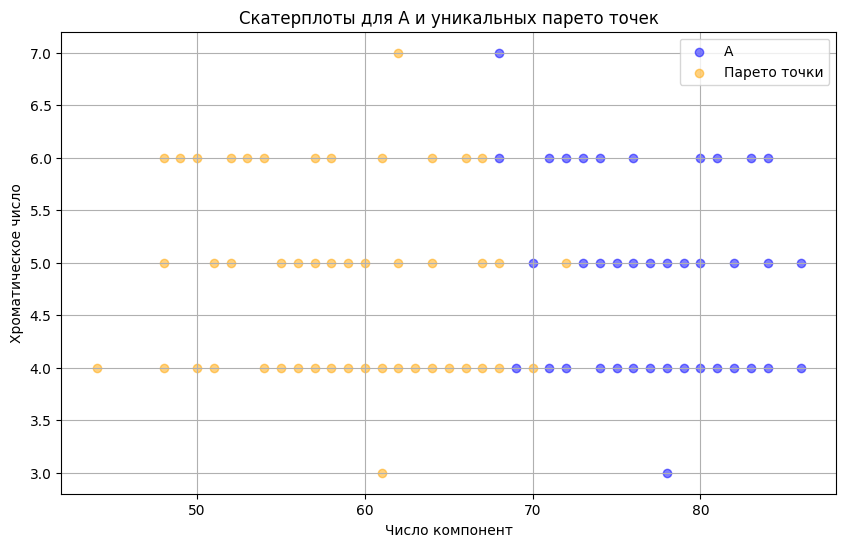

In [35]:
clfr.draw_A()